# Ryhmä-190

## Python-paketit

In [57]:
# Jupyter-notebookissa voi asentaa paketit samaan tapaan kuin komentoriviltä.
# Tähän käytetään "magic commandeja", jotka alkavat %-merkillä.
# Näiden asentamisessa voi mennä muutama minuutti, mutta sen jälkeen niitä ei tarvitse asentaa uudestaan. 
%pip install seaborn
#%pip install mlflow azureml azureml-core azureml-mlflow azure-identity


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import KFold, cross_val_score
#from azureml.core import Workspace
#from azure.identity import InteractiveBrowserCredential
#import mlflow

## MLFlow-seuranta (ei tällä hetkellä käytössä)

Tarkistetaan ajoympäristö (Azure vai oma kone) ja autentikoidutaan sen mukaan.

In [59]:
def is_running_in_azure():
    return 'AZUREML_RUN_ID' in os.environ

def get_workspace():
    if is_running_in_azure():
        return Workspace.from_config()
    else:
        return Workspace(subscription_id='1c0e26b6-0fcb-4b6d-911c-2a0836275ea4',
                         resource_group='rg-AML',
                         workspace_name='aml-data_science_masters')
#ws = get_workspace()

In [60]:
#mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
#experiment_name = 'group-190-tracking'
#mlflow.set_experiment(experiment_name)
#mlflow.autolog()

## Tietoaineistojen lataaminen

In [61]:
df_train = pd.read_csv('../data/train.csv', encoding='utf-8', header=0)
df_test = pd.read_csv('../data/test.csv', encoding='utf-8', header=0)

In [62]:
# Esikatselu
df_train

,ID,log_pSat_Pa,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,...,ester,ether (alicyclic),nitrate,nitro,aromatic hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester
0,0,-11.295070,224.016832,23,6,9,0,4,485.0,40.0,...,0,1,0,0,0,0,0,2,0,0
1,1,-4.782500,310.064845,35,9,10,2,1,236.0,40.0,...,0,0,2,0,0,0,0,1,0,0
2,2,-6.204319,368.033938,37,10,13,2,1,308.0,40.0,...,0,0,1,0,0,1,0,1,0,0
3,3,-9.672591,299.012475,29,7,12,1,4,769.0,3.0,...,0,0,1,0,0,0,0,1,1,0
4,4,-4.252058,202.011353,20,7,7,0,1,77.0,32.0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26632,31632,-1.210727,221.017166,22,6,8,1,1,47.0,37.0,...,0,1,1,0,0,0,0,1,0,0
26633,31633,-7.525230,222.001182,21,6,9,0,3,323.0,12.0,...,0,0,0,0,0,0,1,0,0,0
26634,31634,-8.852094,287.012475,28,6,12,1,4,362.0,11.0,...,0,0,1,0,0,0,1,2,0,0
26635,31635,-6.564478,284.996825,26,6,12,1,3,322.0,35.0,...,0,0,1,0,0,0,1,1,1,0


In [63]:
# Sarakkeiden nimet
list(df_train.columns)

['ID',
 'log_pSat_Pa',
 'MW',
 'NumOfAtoms',
 'NumOfC',
 'NumOfO',
 'NumOfN',
 'NumHBondDonors',
 'NumOfConf',
 'NumOfConfUsed',
 'parentspecies',
 'C=C (non-aromatic)',
 'C=C-C=O in non-aromatic ring',
 'hydroxyl (alkyl)',
 'aldehyde',
 'ketone',
 'carboxylic acid',
 'ester',
 'ether (alicyclic)',
 'nitrate',
 'nitro',
 'aromatic hydroxyl',
 'carbonylperoxynitrate',
 'peroxide',
 'hydroperoxide',
 'carbonylperoxyacid',
 'nitroester']

## Datan tutkiminen

Tänne voimme lisätä visualisointeja ja muuta, mikä auttaa hahmottamaan datan sisältöä, esimerkiksi lineaarisia ja ei-lineaarisia suhteita.

<Axes: xlabel='log_pSat_Pa', ylabel='Count'>

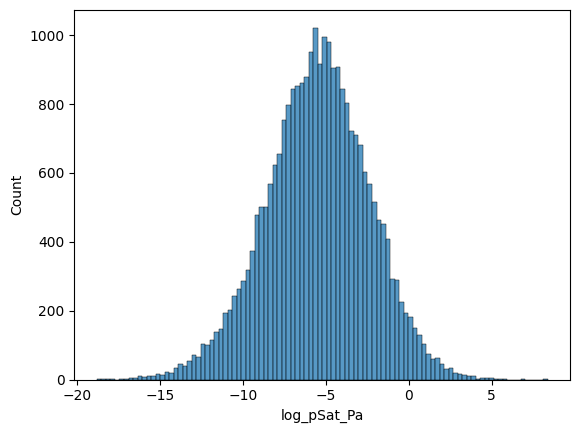

In [64]:
# Pelkän log_pSat_Pa jakauma
sns.histplot(df_train['log_pSat_Pa'])

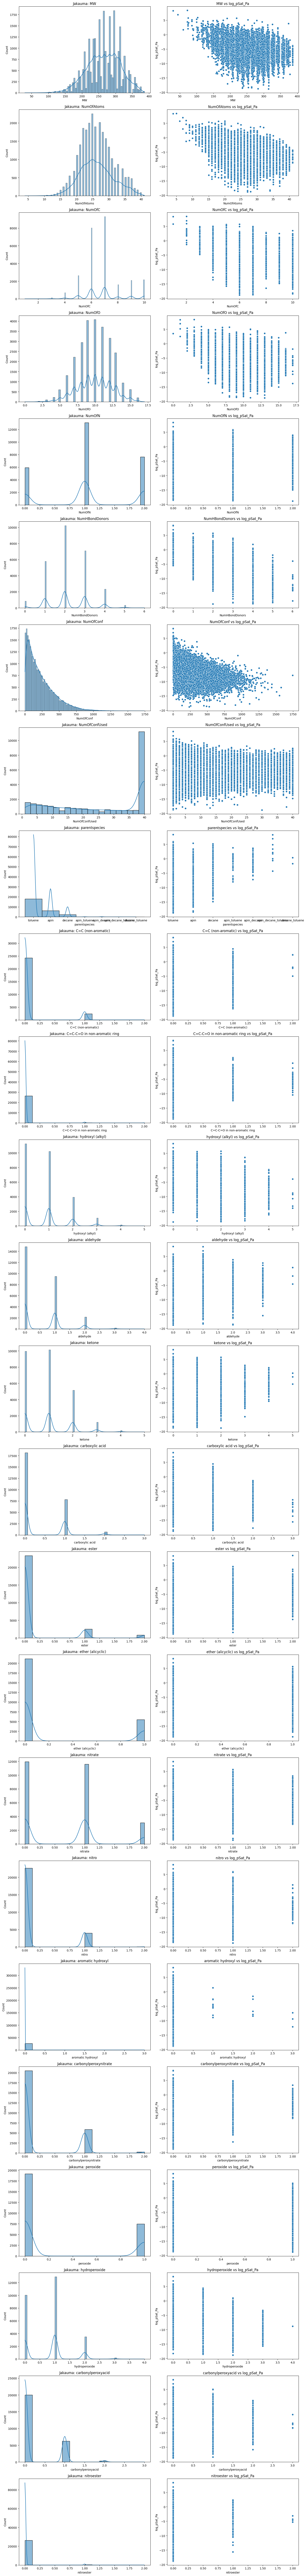

In [65]:
# Jokaisen muuttujan jakauma ja korrelaatio log_pSat_Pa kanssa
cols = df_train.drop(columns=['ID', 'log_pSat_Pa']).columns
num_cols = len(cols)
fig, axes = plt.subplots(num_cols, 2, figsize=(15, 5 * num_cols))

for i, column in enumerate(cols):
    sns.histplot(df_train[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Jakauma: {column}')
    
    sns.scatterplot(data=df_train, x=column, y='log_pSat_Pa', ax=axes[i, 1])
    axes[i, 1].set_title(f'{column} vs log_pSat_Pa')

plt.tight_layout()
plt.show()

## Esiprosessointi

In [66]:
df_train['parentspecies'] = df_train['parentspecies'].astype('category')
df_train['parentspecies'] = df_train['parentspecies'].cat.codes
df_test['parentspecies'] = df_test['parentspecies'].astype('category')
df_test['parentspecies'] = df_test['parentspecies'].cat.codes

## Mallien kouluttaminen

In [67]:
X_train, y_train = df_train.drop(columns=['log_pSat_Pa', 'ID']), df_train['log_pSat_Pa']
X_test = df_test.drop(columns=['ID'])

Erilaisia malleja alla. Kaikki mallit käyttävät samaa nimeä `model`, eli vain viimeisenä koulutettu menee testeihin ja tallentuu.

### 1. Dummy

In [68]:
model = DummyRegressor(strategy='mean')
model.fit(X_train, y_train)

df_test['log_pSat_Pa'] = model.predict(X_test)

2024/11/21 11:25:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4d98571f-4846-466a-afd7-93a9b6dafdf7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/11/21 11:25:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\mikkokallio\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Han

🏃 View run cool_nail_4vcjgkq7 at: https://swedencentral.api.azureml.ms/mlflow/v2.0/subscriptions/1c0e26b6-0fcb-4b6d-911c-2a0836275ea4/resourceGroups/rg-AML/providers/Microsoft.MachineLearningServices/workspaces/aml-data_science_masters/#/experiments/e59c04c4-74a6-4c62-86e6-370ea69518dd/runs/4d98571f-4846-466a-afd7-93a9b6dafdf7
🧪 View experiment at: https://swedencentral.api.azureml.ms/mlflow/v2.0/subscriptions/1c0e26b6-0fcb-4b6d-911c-2a0836275ea4/resourceGroups/rg-AML/providers/Microsoft.MachineLearningServices/workspaces/aml-data_science_masters/#/experiments/e59c04c4-74a6-4c62-86e6-370ea69518dd


2024/11/21 11:25:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 4d98571f-4846-466a-afd7-93a9b6dafdf7. Failed operations: [RestException(\'BAD_REQUEST: Response: {\\\'Error\\\': {\\\'Code\\\': \\\'UserError\\\', \\\'Severity\\\': None, \\\'Message\\\': "Could not log all inputs as datasets:\\\\nCREATE can\\\'t modify existing entity, please use UPDATE.", \\\'MessageFormat\\\': None, \\\'MessageParameters\\\': None, \\\'ReferenceCode\\\': None, \\\'DetailsUri\\\': None, \\\'Target\\\': None, \\\'Details\\\': [], \\\'InnerError\\\': None, \\\'DebugInfo\\\': None, \\\'AdditionalInfo\\\': None}, \\\'Correlation\\\': {\\\'operation\\\': \\\'611feadb50d6cc30323f55348b0c399d\\\', \\\'request\\\': \\\'ea26db68074b612a\\\'}, \\\'Environment\\\': \\\'swedencentral\\\', \\\'Location\\\': \

### 2. Yksinkertainen regressio

In [69]:
model = LinearRegression()
model.fit(X_train, y_train)

df_test['log_pSat_Pa'] = model.predict(X_test)

2024/11/21 11:25:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1e1ada63-e60a-4f43-9de3-05c9640b3e63', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/11/21 11:25:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\mikkokallio\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Han

🏃 View run plum_station_px40xj2c at: https://swedencentral.api.azureml.ms/mlflow/v2.0/subscriptions/1c0e26b6-0fcb-4b6d-911c-2a0836275ea4/resourceGroups/rg-AML/providers/Microsoft.MachineLearningServices/workspaces/aml-data_science_masters/#/experiments/e59c04c4-74a6-4c62-86e6-370ea69518dd/runs/1e1ada63-e60a-4f43-9de3-05c9640b3e63
🧪 View experiment at: https://swedencentral.api.azureml.ms/mlflow/v2.0/subscriptions/1c0e26b6-0fcb-4b6d-911c-2a0836275ea4/resourceGroups/rg-AML/providers/Microsoft.MachineLearningServices/workspaces/aml-data_science_masters/#/experiments/e59c04c4-74a6-4c62-86e6-370ea69518dd


2024/11/21 11:26:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1e1ada63-e60a-4f43-9de3-05c9640b3e63. Failed operations: [RestException(\'BAD_REQUEST: Response: {\\\'Error\\\': {\\\'Code\\\': \\\'UserError\\\', \\\'Severity\\\': None, \\\'Message\\\': "Could not log all inputs as datasets:\\\\nCREATE can\\\'t modify existing entity, please use UPDATE.", \\\'MessageFormat\\\': None, \\\'MessageParameters\\\': None, \\\'ReferenceCode\\\': None, \\\'DetailsUri\\\': None, \\\'Target\\\': None, \\\'Details\\\': [], \\\'InnerError\\\': None, \\\'DebugInfo\\\': None, \\\'AdditionalInfo\\\': None}, \\\'Correlation\\\': {\\\'operation\\\': \\\'ac261adff73e44f2769aa3f7c8cf0c23\\\', \\\'request\\\': \\\'54de9a64df66b20e\\\'}, \\\'Environment\\\': \\\'swedencentral\\\', \\\'Location\\\': \

### 3. Random Forest

In [70]:
model = RandomForestRegressor(random_state=190)
model.fit(X_train, y_train)

df_test['log_pSat_Pa'] = model.predict(X_test)

2024/11/21 11:26:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5dc442cd-1afc-4e4a-ae5f-fd6fceb9690a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/11/21 11:26:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\mikkokallio\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Han

🏃 View run wheat_caravan_fhv26xlx at: https://swedencentral.api.azureml.ms/mlflow/v2.0/subscriptions/1c0e26b6-0fcb-4b6d-911c-2a0836275ea4/resourceGroups/rg-AML/providers/Microsoft.MachineLearningServices/workspaces/aml-data_science_masters/#/experiments/e59c04c4-74a6-4c62-86e6-370ea69518dd/runs/5dc442cd-1afc-4e4a-ae5f-fd6fceb9690a
🧪 View experiment at: https://swedencentral.api.azureml.ms/mlflow/v2.0/subscriptions/1c0e26b6-0fcb-4b6d-911c-2a0836275ea4/resourceGroups/rg-AML/providers/Microsoft.MachineLearningServices/workspaces/aml-data_science_masters/#/experiments/e59c04c4-74a6-4c62-86e6-370ea69518dd


2024/11/21 11:27:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 5dc442cd-1afc-4e4a-ae5f-fd6fceb9690a. Failed operations: [RestException(\'BAD_REQUEST: Response: {\\\'Error\\\': {\\\'Code\\\': \\\'UserError\\\', \\\'Severity\\\': None, \\\'Message\\\': "Could not log all inputs as datasets:\\\\nCREATE can\\\'t modify existing entity, please use UPDATE.", \\\'MessageFormat\\\': None, \\\'MessageParameters\\\': None, \\\'ReferenceCode\\\': None, \\\'DetailsUri\\\': None, \\\'Target\\\': None, \\\'Details\\\': [], \\\'InnerError\\\': None, \\\'DebugInfo\\\': None, \\\'AdditionalInfo\\\': None}, \\\'Correlation\\\': {\\\'operation\\\': \\\'ae8b5a5875bad43f850a3063b2431c58\\\', \\\'request\\\': \\\'5f201a705fdf7754\\\'}, \\\'Environment\\\': \\\'swedencentral\\\', \\\'Location\\\': \

## Mallien arviointi

In [71]:
### Train loss
y_train_pred = model.predict(X_train)
train_loss = mean_squared_error(y_train, y_train_pred)

### 5-fold cross-validation
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=190)
mse_scorer = make_scorer(mean_squared_error)
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=mse_scorer)
cv_loss_mean = cv_scores.mean()

r2_train = r2_score(y_train, y_train_pred)
r2_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2').mean()

print('Train loss:', train_loss)
print('CV loss mean:', cv_loss_mean)
print('Train R^2:', r2_train)
print('CV R^2:', r2_cv)

Train loss: 0.38874301621017565
CV loss mean: 2.77554847201679
Train R^2: 0.9600684248066436
CV R^2: 0.7148233122842106


## Ennustuksen tallentaminen

In [72]:
df_test[['ID', 'log_pSat_Pa']].to_csv('../submission/submission.csv', index=False)